Devectorize.jl
========

Front matter
------------
This notebook was created in Jupyter using Julia 0.5.0-dev+411.  It is intended to demonstrate some of the functionality of the Julia package [Devectorize.jl](https://github.com/lindahua/Devectorize.jl) by Dahua Lin.  

Questions?  Contact [Victor Minden](vminden@stanford.edu).

Required packages
----------------

- Devectorize.jl (demonstrated package)
- PyPlot.jl (plotting)

Note that all packages can be obtained through the typical Pkg.add() method

In [3]:
# Set parameters for package demonstration
n = (Int)(1e6);
# number of MC trials
nMC = 20;

In Matlab code, loops are slow and therefore to be avoided as much as possible.  This has led to an obsession with *vectorization*.  Let's consider the example of taking two arrays and computing their centered dot product, 
$$u = (x - \bar{x})^T(y-\bar{y}).$$

In [4]:
# Properly vectorized code
function vectorized_eval{T<:Real}(x::Array{T},y::Array{T})
    u = sum( (x .- mean(x)) .* (y .- mean(y)) )
end
x = rand(n);
y = rand(n);

u = vectorized_eval(x,y);

What you might not know is that vectorized code can actually be very inefficient when the alternative is *compiled code with appropriate data access patterns*.

In [5]:
# Hand-written loop following example from benchmark for devectorize
function handloop_eval{T<:Real}(x::Array{T},y::Array{T})
    n = length(x);
    # calculate mean(x)
    sx = 0.
    for i = 1 : n
        sx += x[i]
    end
    mx = sx / n

    # calculate mean(y)
    sy = 0.
    for i = 1 : n
        sy += y[i]
    end
    my = sy / n

    # calculate shift dot
    u = 0.
    for i = 1 : n
        u += (x[i] - mx) * (y[i] - my)
    end
end
u = handloop_eval(x,y);

In [4]:
# Explicit timing comparison
t_vector = @elapsed for i = 1:nMC
                        u = vectorized_eval(x,y);
                    end
t_handloop = @elapsed for i = 1:nMC
                        u = handloop_eval(x,y);
                      end
t_vector /= nMC;
t_handloop /= nMC;
println("Average time for vectorized function");
@show t_vector;
println("Average time for hand-rolled function");
@show t_handloop;

#Speed up factor
@show t_vector / t_handloop;

Average time for vectorized function
t_vector = 0.013307988100000001
Average time for hand-rolled function
t_handloop = 0.0012306255000000001
t_vector / t_handloop = 10.814003204061674


As we see (varies by machine), the hand-written loop can be 10X faster or more!  This is because of all the extra looping over data and casting and the like that can occur in vectorization.  However, in Julia, we can compile whatever code we want, so we can get the added speed.  Unfortunately, the hand-written function is much grosser and longer than the vectorized one.  

Enter Devectorize.

In [6]:
using Devectorize;

In [7]:
# Properly Devectorized code
function devectorized_eval{T<:Real}(x::Array{T},y::Array{T})
    @devec u = sum( (x .- mean(x)) .* (y .- mean(y)) )
end
u = vectorized_eval(x,y);

In [10]:
t_devector = @elapsed for i = 1:nMC
                        u = devectorized_eval(x,y);
                    end

t_devector /= nMC;

println("Average time for devectorized function");
@show t_devector;

#Speed up factor
@show t_vector / t_devector;


Average time for devectorized function
t_devector = 0.00250504425
t_vector / t_devector = 5.312476256656944


The results aren't as good as writing a hand-unrolled loop, but a factor of ~5X over the vectorized code is not too shabby!  Note especially that we haven't had to do anything except add the decorator "@devec".

Functions on which devectorization works
======================

- Simple elementwise arithmetic

In [13]:
@devec begin
    u1 = x .+ y;
    u2 = x .- y;
    u3 = x .* y;
    u4 = x ./ y;
    u5 = x .^ y;
end;

- Simple elementwise comparisons

In [14]:
@devec begin
    u1 = x .== y;
    u2 = x .< y;
    u3 = x .> y;
    u4 = x .!= y;
    u5 = x .<= y;
    u6 = x .>= y;
end;

- Trigonometric functions
- Exponentials
- Logs
- Rounding / ceiling / etc.

New to Devectorize
-----------------
Devectorize includes a couple of non-base Julia functions to aid in devectorization.  Here we demonstrate them.  

- The first is "sqr".  This is functionally equivalent to x.^2 or x.*x.

In [19]:
@devec u = sqr(x);

- The next is "rcp", which is functionally equivalent to 1./x.

In [20]:
@devec u = rcp(x);

1000000-element Array{Float64,1}:
   1.91592
   1.46652
  26.8548 
   1.22956
   1.00156
   3.91393
 335.315  
   2.03833
   1.04536
   1.33833
   1.33462
   1.96934
   1.26363
   ⋮      
   1.61141
   2.23612
  15.8452 
   2.24319
   2.81024
   2.2123 
   8.59961
   5.40616
   4.75273
   2.63967
   4.07015
   1.75052

- The last is "blend", which requires some explanation. Blend takes in an array of conditions, an array of things to return if the condition is true, and an array of things to return if the condition is false.  Consider the example below.

In [28]:
x = [5 for i = 1:n];
y = [10 for i = 1:n];
c = rand(n) .> 0.5;
#uncomment semicolon to see result
@devec u = blend(c,x,y);

Example
=======
We took the opportunity to do make some timing plots to visualize the effect of devectorization.  The code for the actual tests is the Devectorize benchmark code.  It appears below for those who are interested.

In [8]:
repeat = 20
# prepare data

m = 1000
n = 1000
a = zeros(m, n)
b = zeros(m, n)
c = zeros(m, n)


# simple element-wise

type simple_ewise end
formula(::simple_ewise) = "(a - b).^2 + c"

function vec_eval{T<:Real}(::simple_ewise, a::Array{T}, b::Array{T}, c::Array{T})
    r = sqr(a - b) + c   # Note: Devectorize defines a sqr on arrays
end

function devec_eval{T<:Real}(::simple_ewise, a::Array{T}, b::Array{T}, c::Array{T})
    @devec r = sqr(a - b) + c
end

function hand_loop{T<:Real}(::simple_ewise, a::Array{T}, b::Array{T}, c::Array{T})
    r = similar(a)
    for i = 1 : length(a)
        v = (a[i] - b[i])
        r[i] = v * v + c[i]
    end
end


# complex element-wise

type complex_ewise end
formula(::complex_ewise) = "log(exp((a - b).^2) + exp(a + b)) - c .* log(c)"

function vec_eval{T<:Real}(::complex_ewise, a::Array{T}, b::Array{T}, c::Array{T})
    r = log(exp((a - b).^2) + exp(a + b)) - c .* log(c)
end

function devec_eval{T<:Real}(::complex_ewise, a::Array{T}, b::Array{T}, c::Array{T})
    @devec r = log(exp((a - b).^2) + exp(a + b)) - c .* log(c)
end

function hand_loop{T<:Real}(::complex_ewise, a::Array{T}, b::Array{T}, c::Array{T})
    r = similar(a)
    for i = 1 : length(a)
        r[i] = log(exp((a[i] - b[i]).^2) + exp(a[i] + b[i])) - c[i] .* log(c[i])
    end
end

# shift dot

type shift_dot end
formula(::shift_dot) = "sum( (a - mean(a)) .* (b - mean(b)) )"

function vec_eval{T<:Real}(::shift_dot, a::Array{T}, b::Array{T}, c::Array{T})
    r = sum( (a .- mean(a)) .* (b .- mean(b)) )
end

function devec_eval{T<:Real}(::shift_dot, a::Array{T}, b::Array{T}, c::Array{T})
    @devec r = sum( (a .- mean(a)) .* (b .- mean(b)) )
end

function hand_loop{T<:Real}(::shift_dot, a::Array{T}, b::Array{T}, c::Array{T})
    n = length(a)

    # calculate mean(a)
    sa = 0.
    for i = 1 : n
        sa += a[i]
    end
    ma = sa / n

    # calculate mean(b)
    sb = 0.
    for i = 1 : n
        sb += b[i]
    end
    mb = sb / n

    # calculate shift dot
    r = 0.
    for i = 1 : n
        r += (a[i] - ma) * (b[i] - mb)
    end
end

# column wise sum

type colwise_sum end
formula(::colwise_sum) = "sum(a, 1)"

function vec_eval{T<:Real}(::colwise_sum, a::Array{T}, b::Array{T}, c::Array{T})
    r = sum(a, 1)
end

function devec_eval{T<:Real}(::colwise_sum, a::Array{T}, b::Array{T}, c::Array{T})
    @devec r = sum(a, 1)
end

function hand_loop{T<:Real}(::colwise_sum, a::Array{T}, b::Array{T}, c::Array{T})
    m, n = size(a)
    r = zeros(1, n)
    for j = 1 : n
        s = 0.
        for i = 1 : m
            s += a[i, j]
        end
        r[j] = s
    end
end

# row-wise sum

type rowwise_sum end
formula(::rowwise_sum) = "sum(a, 2)"

function vec_eval{T<:Real}(::rowwise_sum, a::Array{T}, b::Array{T}, c::Array{T})
    r = sum(a, 2)
end

function devec_eval{T<:Real}(::rowwise_sum, a::Array{T}, b::Array{T}, c::Array{T})
    @devec r = sum(a, 2)
end

function hand_loop{T<:Real}(::rowwise_sum, a::Array{T}, b::Array{T}, c::Array{T})
    m, n = size(a)
    r = zeros(1, n)
    for j = 1 : n
        for i = 1 : m
            r[i] += a[i,j]
        end
    end
end


# col-wise euclidean

type colwise_eucdist end
formula(::colwise_eucdist) = "sqrt(sum((a - b).^2, 1))"

function vec_eval{T<:Real}(::colwise_eucdist, a::Array{T}, b::Array{T}, c::Array{T})
    r = sqrt(sum(sqr(a - b), 1))
end

function devec_eval{T<:Real}(::colwise_eucdist, a::Array{T}, b::Array{T}, c::Array{T})
    @devec r = sqrt(sum(sqr(a - b), 1))
end

function hand_loop{T<:Real}(::colwise_eucdist, a::Array{T}, b::Array{T}, c::Array{T})
    m, n = size(a)
    r = zeros(1, n)
    for j = 1 : n
        s = 0.
        for i = 1 : m
            v = a[i, j] - b[i, j]
            s += v * v
        end
        r[j] = sqrt(s)
    end
end;




In [10]:
macro my_bench(Name,p)
    quote
        # create task
        println("bench: ", $(string(Name)))
        task = ($Name)()

        vec_eval(task, a, b, c)
        t1 = @elapsed for i = 1 : repeat
            vec_eval(task, a, b, c)
        end
        @printf "    vec_eval   : %8.4f sec  |  gain = %7.4f\n" t1 t1 / t1

        devec_eval(task, a, b, c)
        t2 = @elapsed for i = 1 : repeat
            devec_eval(task, a, b, c)
        end
        @printf "    devec_eval : %8.4f sec  |  gain = %7.4f\n" t2 t1 / t2

        hand_loop(task, a, b, c)
        t3 = @elapsed for i = 1 : repeat
            hand_loop(task, a, b, c)
        end
        @printf "    hand_loop  : %8.4f sec  |  gain = %7.4f\n" t3 t1 / t3

        t_vec[$p] = t1;
        t_devec[$p] = t2;
        t_hand[$p] = t3;
        println()
    end
end




#  Benchmarks

t_vec   = zeros(6);
t_devec = zeros(6);
t_hand  = zeros(6);

@my_bench(simple_ewise,1)
@my_bench(complex_ewise, 2)
@my_bench(shift_dot, 3)
@my_bench(colwise_sum, 4)
@my_bench(rowwise_sum, 5)
@my_bench(colwise_eucdist, 6)

bench: simple_ewise
    vec_eval   :   0.2737 sec  |  gain =  1.0000
    devec_eval :   0.1002 sec  |  gain =  2.7311
    hand_loop  :   0.1247 sec  |  gain =  2.1947

bench: complex_ewise
    vec_eval   :   1.4143 sec  |  gain =  1.0000
    devec_eval :   0.4271 sec  |  gain =  3.3118
    hand_loop  :   0.3975 sec  |  gain =  3.5581

bench: shift_dot
    vec_eval   :   0.2688 sec  |  gain =  1.0000
    devec_eval :   0.0280 sec  |  gain =  9.5983
    hand_loop  :   0.0404 sec  |  gain =  6.6521

bench: colwise_sum
    vec_eval   :   0.0157 sec  |  gain =  1.0000
    devec_eval :   0.0669 sec  |  gain =  0.2342
    hand_loop  :   0.0269 sec  |  gain =  0.5816

bench: rowwise_sum
    vec_eval   :   0.0362 sec  |  gain =  1.0000
    devec_eval :   0.0308 sec  |  gain =  1.1759
    hand_loop  :   0.0256 sec  |  gain =  1.4114

bench: colwise_eucdist
    vec_eval   :   0.2752 sec  |  gain =  1.0000
    devec_eval :   0.0526 sec  |  gain =  5.2267
    hand_loop  :   0.0440 sec  |  gain =  6

In [9]:
using PyPlot;

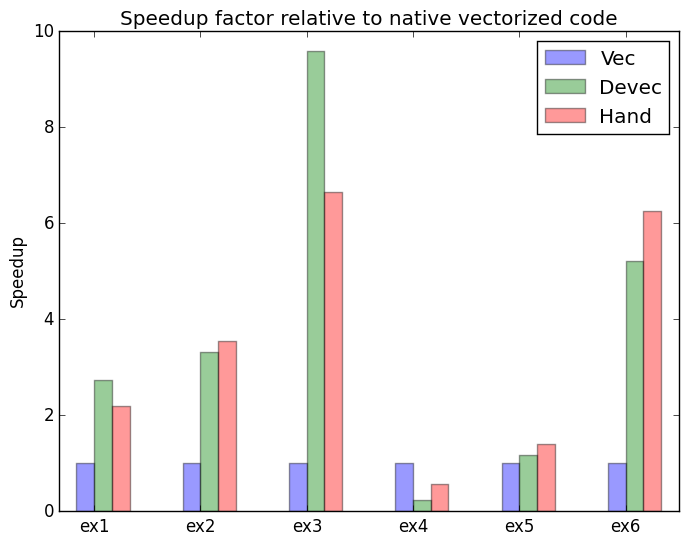

In [13]:
fig, ax = subplots()

index = 6*(1:6)
bar_width = 1

opacity = 0.4

rects1 = bar(index, t_vec./t_vec, bar_width,
                 alpha=opacity,
                color="blue",
                label="Vec")
rects2 = bar(index+bar_width, t_vec./t_devec, bar_width,
                 alpha=opacity,
                color="green",
label="Devec")
rects3 = bar(index + 2*bar_width, t_vec./t_hand, bar_width,
                 alpha=opacity,
color="red",
label="Hand")

legend()

ylabel("Speedup")
title("Speedup factor relative to native vectorized code")
xticks(index+bar_width)
ax[:set_xticklabels](("ex1","ex2","ex3","ex4","ex5","ex6"));


- ex1: simple_ewise "(a - b).^2 + c"
- ex2: complex_ewise "log(exp((a - b).^2) + exp(a + b)) - c .* log(c)"
- ex3: shift_dot "sum( (a - mean(a)) .* (b - mean(b)) )"
- ex4: colwise_sum "sum(a, 1)"
- ex5: rowwise_sum "sum(a, 2)"
- ex6: colwise_eucdist "sqrt(sum((a - b).^2, 1))"